## **Table of Contents:**
* [Fake Data](#1)
* [Gradient Boosting](#2)
* [Model on Fake Data](#3)
* [Tough Cases](#4)

In [59]:
pip install Faker

##### Source:
 - https://faker.readthedocs.io/en/master/#

In [60]:
import pandas as pd
from faker import Faker

In [61]:
fake = Faker(42)

In [62]:
items = [x for x in dir(fake)]
print(items)

['__annotations__', '__class__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_factories', '_factory_map', '_locales', '_map_provider_method', '_select_factory', '_select_factory_choice', '_select_factory_distribution', '_unique_proxy', '_weights', 'aba', 'add_provider', 'address', 'administrative_unit', 'am_pm', 'android_platform_token', 'ascii_company_email', 'ascii_email', 'ascii_free_email', 'ascii_safe_email', 'bank_country', 'bban', 'binary', 'boolean', 'bothify', 'bs', 'building_number', 'cache_pattern', 'catch_phrase', 'century', 'chrome', 'city', 'city_prefix', 'city_suffix', 'color', 'color_name', 'company', 'company_email', 'company

In [63]:
fake.name()

'Robert Dean'

In [64]:
fake.first_name()

'Aaron'

In [65]:
fake.address()

'243 Miller Pass Apt. 773\nNorth Brucehaven, SD 24957'

In [66]:
fake.street_name()

'Cassandra Valleys'

In [67]:
fake.street_address()

'30770 Alexandra Stream Suite 591'

In [68]:
fake.state()

'Rhode Island'

In [69]:
fake.ssn()

'839-83-6269'

In [70]:
fake.zipcode()

'88859'

In [71]:
fake.date_of_birth()

datetime.date(2014, 3, 25)

In [72]:
for _ in range(10):
    print(fake.name())

Michael Wood
Jacqueline Goodman
Karen Franco
Tracy Welch
Jennifer Rhodes
Corey Dixon
Peter Campbell
Roger Thompson
Eric Green
Susan Smith


In [73]:
fake.city()

'Tiffanyport'

In [74]:
fake.address()

'18763 Joshua Fort\nPort Bruceborough, NJ 44094'

In [75]:
fake.text()

'Lawyer middle gun skin. Current yourself light member control street spring. Rise compare agent within technology everyone.'

## Fake Data <a name="1"></a>

In [76]:
def data_creation(entries):
    given_name = []
    surname = []
    street_number=[]
    address_1=[]
    address_2=[]
    suburb=[]
    state = []
    postcode = []
    date_of_birth = []
    soc_sec_id = []
    
    for q in range(entries):
        given_name.append(fake.first_name())
        surname.append(fake.last_name())
        street_number.append(fake.building_number())
        address_1.append(fake.street_suffix())
        address_2.append(fake.street_name())
        suburb.append(fake.city())
        state.append(fake.state())
        postcode.append(fake.zipcode())
        soc_sec_id.append(fake.ssn())
        date_of_birth.append(fake.date_of_birth())
        
    df = pd.DataFrame(list(zip(given_name, surname, street_number, address_1, address_2, suburb,  postcode,state,date_of_birth,soc_sec_id)), 
                      columns= ['given_name', 'surname', 'street_number', 'address_1', 'address_2', 'suburb','postcode', 'state','date_of_birth','soc_sec_id'])
    return df

In [77]:
data_sample=data_creation(entries=10000)


In [78]:
pip install recordlinkage

In [79]:
import recordlinkage
import pandas as pd

In [80]:
from recordlinkage.datasets import load_febrl4

In [81]:
dfA, dfB, true_links = load_febrl4(return_links=True)
from recordlinkage.preprocessing import phonetic
dfA["phonetic_given_name"] = phonetic(dfA["given_name"], "soundex")
dfB["phonetic_given_name"] = phonetic(dfB["given_name"], "soundex")
dfA["phonetic_surname"] = phonetic(dfA["surname"], "soundex")
dfB["phonetic_surname"] = phonetic(dfB["surname"], "soundex")
dfA["initials"] = (dfA["given_name"].str[0]  + dfA["surname"].str[0])
dfB["initials"] = (dfB["given_name"].str[0]  + dfB["surname"].str[0])

dfA["date_of_birth"] = dfA["date_of_birth"].str.replace('-', "")
dfB["date_of_birth"] = dfB["date_of_birth"].str.replace('-', "")
dfA["soc_sec_id"] = dfA["soc_sec_id"].str.replace('-', "")
dfB["soc_sec_id"] = dfB["soc_sec_id"].str.replace('-', "")

In [116]:
from recordlinkage import Compare
def data1(dfA,dfB,blocker=""):
  indexer = recordlinkage.Index()
  if blocker!="":
    indexer.block(blocker)
    candidate_links = indexer.index(dfA, dfB)
  else:
    a=list(dfA.index)
    b=list(dfB.index)
    candidate_links=pd.MultiIndex.from_product([a,b])  
  compare = Compare()
  compare.exact('phonetic_given_name', 'phonetic_given_name', label="phonetic_given_name")
  compare.exact('phonetic_surname', 'phonetic_surname', label='phonetic_surname')
  compare.string('given_name', 'given_name', method='jarowinkler', label="given_name")
  compare.string('surname', 'surname', method='jarowinkler', label="surname")
  compare.string('suburb', 'suburb', method='jarowinkler', label="suburb")
  compare.string('state', 'state', method='jaro_winkler', label="state")
  compare.string('address_1', 'address_1', method='jarowinkler', label="address_1")
  compare.string('address_2', 'address_2', method='jarowinkler', label="address_2")
  compare.string("soc_sec_id","soc_sec_id",method='jarowinkler', label="soc_sec_id")
  compare.string("date_of_birth","date_of_birth",method='jarowinkler', label="date_of_birth")
  features = compare.compute(candidate_links, dfA, dfB)
  return features

## Gradient Boosting <a name="2"></a>

In [117]:
features=data1(dfA,dfB,"initials")
features['Target']=features.index.isin(true_links)
features['Target']=features['Target'].astype(int)

data=features.reset_index(drop=True)
X=data.drop(['Target'],axis=1)
Y=data['Target']

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=42,test_size=0.2)


from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_depth=3, random_state=42).fit(X_train, y_train)


In [118]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
y_pred=clf.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19950
           1       1.00      1.00      1.00       752

    accuracy                           1.00     20702
   macro avg       1.00      1.00      1.00     20702
weighted avg       1.00      1.00      1.00     20702



[0.00000000e+00 0.00000000e+00 4.75963742e-04 3.28931350e-03
 1.97882410e-03 3.66517554e-08 2.65152920e-03 6.38969922e-04
 9.56187920e-01 3.47774432e-02]


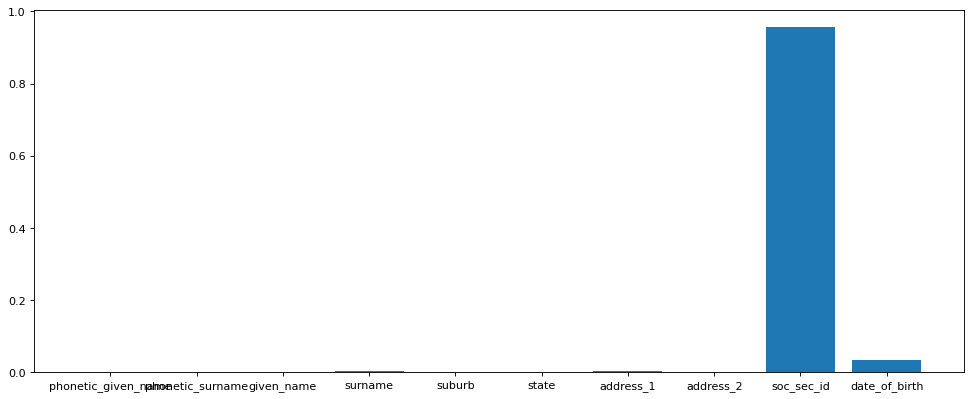

In [119]:
import matplotlib.pyplot as plt

print(clf.feature_importances_)

plt.figure(figsize=(15, 6), dpi=80)
plt.bar(list(X_train.columns), clf.feature_importances_)
plt.show()

## Applying Model on Fake Data <a name="3"></a>

In [140]:

dfA1=data_sample
dfB1=data_sample
dfA1["phonetic_given_name"] = phonetic(dfA1["given_name"], "soundex")
dfB1["phonetic_given_name"] = phonetic(dfB1["given_name"], "soundex")
dfA1["phonetic_surname"] = phonetic(dfA1["surname"], "soundex")
dfB1["phonetic_surname"] = phonetic(dfB1["surname"], "soundex")
dfA1["initials"] = (dfA1["given_name"].str[0]  + dfA1["surname"].str[0])
dfB1["initials"] = (dfB1["given_name"].str[0]  + dfB1["surname"].str[0])

dfA1["date_of_birth"] = dfA1["date_of_birth"].astype(str).str.replace('-', "")
dfB1["date_of_birth"] = dfB1["date_of_birth"].astype(str).str.replace('-', "")
dfA1["soc_sec_id"] = dfA1["soc_sec_id"].astype(str).str.replace('-', "")
dfB1["soc_sec_id"] = dfB1["soc_sec_id"].astype(str).str.replace('-', "")

In [139]:
features=data1(dfA1,dfB1,"initials")

In [141]:
features['Match']=clf.predict_proba(features)[:,1]

features.reset_index(inplace=True)
features=features[features["level_0"]!=features["level_1"]]

In [150]:
features.sort_values(['Match'],ascending=False,inplace=True)
features.head(6)


,level_0,level_1,phonetic_given_name,phonetic_surname,given_name,surname,suburb,state,address_1,address_2,soc_sec_id,date_of_birth,Match
101195,4980,4756,1,0,0.642857,0.630952,0.384722,0.566667,0.977778,0.451282,0.0,0.666667,0.65108
101107,4756,4980,1,0,0.642857,0.630952,0.384722,0.566667,0.977778,0.451282,0.0,0.666667,0.65108
51602,6020,4695,0,0,0.633333,0.518519,0.411255,0.502646,1.000000,0.466450,0.0,0.583333,0.37018
178063,9696,5067,0,0,0.567100,0.476190,0.375631,0.464286,1.000000,0.483333,0.0,0.666667,0.37018
49298,4695,6020,0,0,0.633333,0.518519,0.411255,0.502646,1.000000,0.466450,0.0,0.583333,0.37018
133496,314,6123,0,0,0.561905,0.676190,0.301347,0.658333,1.000000,0.494872,0.0,0.800000,0.37018


In [151]:

dfA1.iloc[[features['level_0'].values[0],features['level_1'].values[0]]]

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,phonetic_given_name,phonetic_surname,initials
4980,Rachel,Benitez,6939,Junctions,Jeffery Burgs,North Brianmouth,97294,Washington,19340903,320071789,R240,B532,RB
4756,Russell,Barnett,888,Junction,Fox Shoals,Ronaldstad,28333,Utah,19240611,846454364,R240,B653,RB


In [152]:
dfA1.iloc[[features['level_0'].values[2],features['level_1'].values[2]]]

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,phonetic_given_name,phonetic_surname,initials
6020,Jacob,Schneider,00909,Bypass,Laura Manor,Dariushaven,52160,Wisconsin,19920709,309295022,J210,S536,JS
4695,Jacqueline,Sutton,20550,Bypass,Jeanette Coves,Joyberg,55419,Georgia,20050823,178761674,J245,S350,JS


In [153]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Tough Cases <a name="4"></a>

In [154]:
sample=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ToughCases.csv")

In [155]:
sample

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
0,Alex,Smith,29,rapanea street,chelseahouse,evanston,60637,IL,19970523,5095261.0
1,Alexi,Smith,29,rapanea street,chelseahouse,evanston,60637,IL,19931006,5095281.0
2,Alex,Smith,29,rapanea street,chelseahouse,evanston,60637,IL,19970523,5095261.0
3,Alexi,Smith,46,baker street,hydepark,evanston,60633,IL,19931006,5095281.0
4,Alex,Smith,29,rapanea street,chelseahouse,evanston,60637,IL,19970523,5095261.0
5,Alexi,Smith,46,baker street,hydepark,lincoln park,60623,IL,19970523,5095261.0
6,Jack,Black,78,amber street,chelseahouse,evnaston,61234,NY,19970523,5095261.0
7,Brad,Pitt,69,ohio street,hydepark,lincoln park,60615,IL,19970523,5095261.0
8,Alex,Smith,29,rapanea street,chelseahouse,evanston,60637,IL,19970523,NaN
9,Alexi,Smith,29,rapanea street,chelseahouse,evanston,60637,IL,19931006,5095281.0


In [156]:
dfA1=sample
dfB1=sample
dfA1["phonetic_given_name"] = phonetic(dfA1["given_name"], "soundex")
dfB1["phonetic_given_name"] = phonetic(dfB1["given_name"], "soundex")
dfA1["phonetic_surname"] = phonetic(dfA1["surname"], "soundex")
dfB1["phonetic_surname"] = phonetic(dfB1["surname"], "soundex")
dfA1["initials"] = (dfA1["given_name"].str[0]  + dfA1["surname"].str[0])
dfB1["initials"] = (dfB1["given_name"].str[0]  + dfB1["surname"].str[0])

dfA1["date_of_birth"] = dfA1["date_of_birth"].astype(str).str.replace('-', "")
dfB1["date_of_birth"] = dfB1["date_of_birth"].astype(str).str.replace('-', "")
dfA1["soc_sec_id"] = dfA1["soc_sec_id"].astype(str).str.replace('-', "")
dfB1["soc_sec_id"] = dfB1["soc_sec_id"].astype(str).str.replace('-', "")

In [157]:
features=data1(dfA1,dfB1)

In [158]:
features['Match']=clf.predict_proba(features)[:,1]

features.reset_index(inplace=True)
features=features[features["level_0"]!=features["level_1"]]

In [159]:
features.sort_values(['Match'],ascending=False).head(100)

,level_0,level_1,phonetic_given_name,phonetic_surname,given_name,surname,suburb,state,address_1,address_2,soc_sec_id,date_of_birth,Match
40,4,0,1,1,1.00,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,0.999959
4,0,4,1,1,1.00,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,0.999959
42,4,2,1,1,1.00,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,0.999959
91,9,1,1,1,1.00,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,0.999959
2,0,2,1,1,1.00,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,0.999959
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,8,6,0,0,0.00,0.000000,0.966667,0.0,0.815873,1.000000,0.0,1.000000,0.029501
83,8,3,1,1,0.96,1.000000,1.000000,1.0,0.815873,0.541667,0.0,0.666667,0.021717
38,3,8,1,1,0.96,1.000000,1.000000,1.0,0.815873,0.541667,0.0,0.666667,0.021717
78,7,8,0,0,0.00,0.633333,0.541667,1.0,0.616883,0.541667,0.0,1.000000,0.001275


In [160]:
for i in range(0,len(sample),2):
  f1=features[(features['level_0']==i) & (features['level_1']==i+1)]
  display(f1)
  print()
  display(sample.iloc[[i,i+1]])
  print("\n\n\n\n\n")



,level_0,level_1,phonetic_given_name,phonetic_surname,given_name,surname,suburb,state,address_1,address_2,soc_sec_id,date_of_birth,Match
1,0,1,1,1,0.96,1.0,1.0,1.0,1.0,1.0,0.955556,0.666667,0.999934


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,phonetic_given_name,phonetic_surname,initials
0,Alex,Smith,29,rapanea street,chelseahouse,evanston,60637,IL,19970523,5095261.0,A420,S530,AS
1,Alexi,Smith,29,rapanea street,chelseahouse,evanston,60637,IL,19931006,5095281.0,A420,S530,AS


,level_0,level_1,phonetic_given_name,phonetic_surname,given_name,surname,suburb,state,address_1,address_2,soc_sec_id,date_of_birth,Match
23,2,3,1,1,0.96,1.0,1.0,1.0,0.815873,0.541667,0.955556,0.666667,0.999599


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,phonetic_given_name,phonetic_surname,initials
2,Alex,Smith,29,rapanea street,chelseahouse,evanston,60637,IL,19970523,5095261.0,A420,S530,AS
3,Alexi,Smith,46,baker street,hydepark,evanston,60633,IL,19931006,5095281.0,A420,S530,AS


,level_0,level_1,phonetic_given_name,phonetic_surname,given_name,surname,suburb,state,address_1,address_2,soc_sec_id,date_of_birth,Match
45,4,5,1,1,0.96,1.0,0.541667,1.0,0.815873,0.541667,1.0,1.0,0.999722


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,phonetic_given_name,phonetic_surname,initials
4,Alex,Smith,29,rapanea street,chelseahouse,evanston,60637,IL,19970523,5095261.0,A420,S530,AS
5,Alexi,Smith,46,baker street,hydepark,lincoln park,60623,IL,19970523,5095261.0,A420,S530,AS


,level_0,level_1,phonetic_given_name,phonetic_surname,given_name,surname,suburb,state,address_1,address_2,soc_sec_id,date_of_birth,Match
67,6,7,0,0,0.5,0.0,0.541667,0.0,0.644661,0.541667,1.0,1.0,0.999249


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,phonetic_given_name,phonetic_surname,initials
6,Jack,Black,78,amber street,chelseahouse,evnaston,61234,NY,19970523,5095261.0,J200,B420,JB
7,Brad,Pitt,69,ohio street,hydepark,lincoln park,60615,IL,19970523,5095261.0,B630,P300,BP


,level_0,level_1,phonetic_given_name,phonetic_surname,given_name,surname,suburb,state,address_1,address_2,soc_sec_id,date_of_birth,Match
89,8,9,1,1,0.96,1.0,1.0,1.0,1.0,1.0,0.0,0.666667,0.997464


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,phonetic_given_name,phonetic_surname,initials
8,Alex,Smith,29,rapanea street,chelseahouse,evanston,60637,IL,19970523,nan,A420,S530,AS
9,Alexi,Smith,29,rapanea street,chelseahouse,evanston,60637,IL,19931006,5095281.0,A420,S530,AS
